# Android packets analysis
I wanted to monitor which apps on my android phone where using the most my internet connection while idle. Here I will only consider packets' destination addresses, trying to group them by organization, since one can have many endpoints. The purpose is identifying who my phone is sending data to, and see if there's some 
data sent to places I don't want to. Ideally I would expect only organizations of which I have an app installed, and of course Google, since Google services are used by a lot of apps.

## Data gathering
I used [ettercap](https://www.ettercap-project.org/ettercap/) for a MITM attack to my phone while connected to WiFi, and [wireshark](https://www.wireshark.org/) for packet captures. Data comes from wireshark's `Statistics` -> `IPv4 Statistics` -> `All Addresses` tab. This is the data right outside wireshark, after an hour of monitoring:

In [25]:
import pandas as pd
data = pd.read_csv('stats.csv',sep=',',decimal='.')
data.head()

,level,parent,Topic / Item,Count,Average,Min val,Max val,Rate (ms),Percent,Burst rate,Burst start,Unnamed: 11
0,0,NaN,All Addresses,1454,NaN,NaN,NaN,0.0003,100%,0.58,1300.488,NaN
1,1,/All Addresses,69.10.180.70,96,NaN,NaN,NaN,0.0000,6.60%,0.08,4332.651,NaN
2,1,/All Addresses,66.102.1.188,36,NaN,NaN,NaN,0.0000,2.48%,0.08,4574.738,NaN
3,1,/All Addresses,52.38.149.111,26,NaN,NaN,NaN,0.0000,1.79%,0.06,61.716,NaN
4,1,/All Addresses,52.10.60.207,6,NaN,NaN,NaN,0.0000,0.41%,0.02,47.213,NaN


Let's consider only data with `level == 1` since `0` is the sum for all addresses. I will also remove local addresses, since they where only used for ICMP requests:

In [26]:
data = data[data['level'] == 1]
data = data[~data['Topic / Item'].str.contains('192.168.1')]

Next I want to add organization's name of each ip address, using the `whois` command. Since it can be slow I already made a csv with all the organizations:

In [27]:
import subprocess

def whois(address,field):
    command = "whois {} | grep -m 1 {} | cut -d ':' -f2"
    return subprocess.check_output(command.format(address,field), shell=True).decode('utf-8').strip()

def resolve(address):
    res = whois(address,'descr')
    if res == u'':
        res = whois(address, 'org-name')
    if res == u'':
        res = whois(address, 'OrgName')
    if res == u'':
        res = 'Unknown'
    return res

try:
    resolved = pd.read_csv('resolved.csv',header=None,names=['Resolved'])
except:
    resolved = data['Topic / Item'].copy().apply(lambda x: resolve(x))
    resolved.to_csv('resolved.csv')
    resolved = pd.read_csv('resolved.csv',header=None,names=['Resolved'])
resolved[resolved.Resolved.str.contains('PAT/NAT IP addresses POP 0118 for')] = 'Fastweb Networks Block'
resolved[resolved.Resolved.str.contains('Amazon')] = 'Amazon'
data['Organization'] = resolved
data.head()

,level,parent,Topic / Item,Count,Average,Min val,Max val,Rate (ms),Percent,Burst rate,Burst start,Unnamed: 11,Organization
1,1,/All Addresses,69.10.180.70,96,NaN,NaN,NaN,0.0,6.60%,0.08,4332.651,NaN,Motorola Mobility LLC
2,1,/All Addresses,66.102.1.188,36,NaN,NaN,NaN,0.0,2.48%,0.08,4574.738,NaN,Google LLC
3,1,/All Addresses,52.38.149.111,26,NaN,NaN,NaN,0.0,1.79%,0.06,61.716,NaN,Amazon
4,1,/All Addresses,52.10.60.207,6,NaN,NaN,NaN,0.0,0.41%,0.02,47.213,NaN,Amazon
5,1,/All Addresses,35.165.2.110,4,NaN,NaN,NaN,0.0,0.28%,0.02,98.625,NaN,Amazon


I needed to consider different fields of `whois` command to actually have a useful indication of the app that was making the connection. Also some entries had quite a misleading description, which I fixed manually. I didn't actually understand from which app all of the connections where coming from, however I think they are interesting results.

## Analysis

Let's see how much endpoints (ip addresses) there are for each organization:

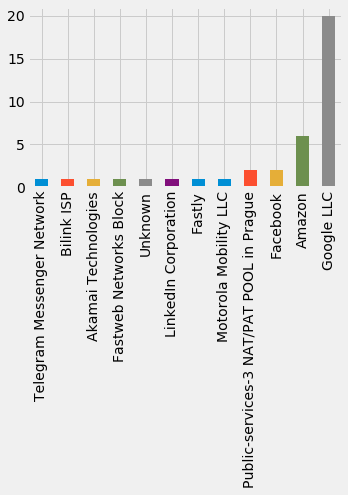

In [29]:
import matplotlib.pyplot as plt
from scipy.constants import golden
plt.style.use('fivethirtyeight')
plt.rc('figure', figsize=(5.0, 5.0/golden))
data['Organization'].value_counts().sort_values().plot.bar()
plt.show()

Google and Amazon seem to be the companies that own most of endpoints my phone sent data to. Now the number of package sent to each company:

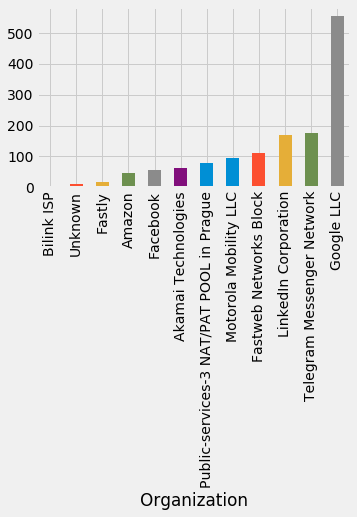

In [31]:
import matplotlib.pyplot as plt
from scipy.constants import golden
plt.style.use('fivethirtyeight')
plt.rc('figure', figsize=(5.0, 5.0/golden))
address_count = data['Count']
address_count.index = data['Organization']
address_count=address_count.groupby(address_count.index).aggregate(sum)
address_count.sort_values().plot.bar()
plt.show()

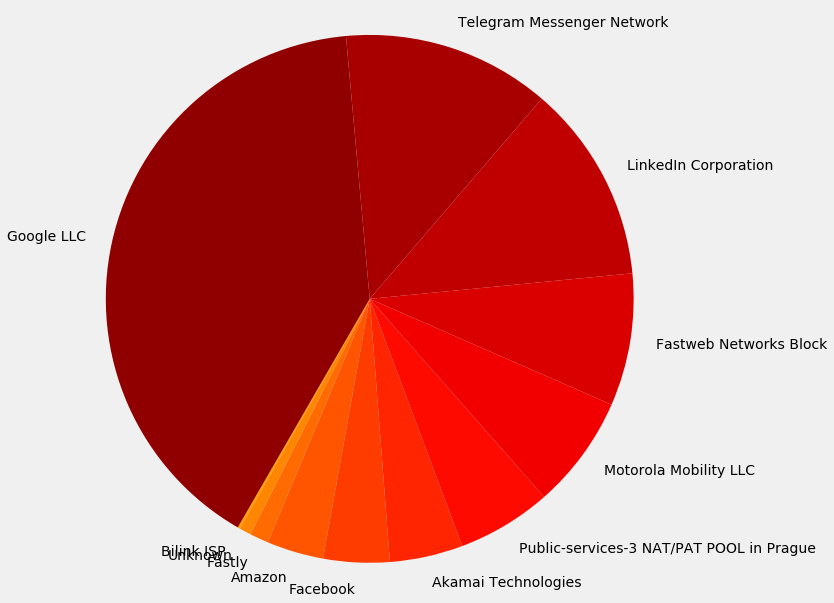

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
color = cm.hot_r(np.linspace(.4,.8, len(address_count)))
address_count.name = ''
address_count.sort_values().plot.pie(figsize=(10,10),colors=color, legend=False,startangle=240)
plt.axis('equal')
plt.show()

## Conclusions
As expected Google uses a lot of data, with geolocalization being on and all the other services. Next are Telegram, which to be fair I expected to be ranked lower since Facebook, which probably means WhatsApp (I don't have Facebook installed), sent a lot less packages. Also LinkedIn needs to be limited, since I don't even use it that much.

I don't really know what's Fastweb Networks Block, but Fastweb is my ISP. Then we have Motorola Mobility LLC, being my phone a Moto G5 I think there are some usage statistics sent, which I will try to disable. 

Then there are some description got by `whois` that I can't really link to any app. I think Amazon may have a higher count in the barplot of ip addresses per organization since many services relay on AWS, while having a low packet count because such apps didn't send a lot of packages. Even if is only the Amazon app, I'm glad it doesn't communicate a lot.

In the end, this will make me reconsider some of my installed apps, like LinkedIn, and try to limit Google's usage of data, if possible.